In [ ]:
import os
import json
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pydicom
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.python.ops import array_ops
from tqdm import tqdm
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, load_model
from math import ceil, floor
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import log_loss
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

print('okay')

okay


In [ ]:
os.listdir('/home/mtp2/rsna_data')

['stage_2_test',
 'stage_2_train.csv',
 'stage_2_train',
 'png_train',
 'train_1000.csv',
 'stage_2_sample_submission.csv']

In [ ]:
BASE_PATH = '/home/mtp2/rsna_data/'
TRAIN_DIR = 'stage_2_train/'
TEST_DIR = 'stage_2_test/'
train_df = pd.read_csv(BASE_PATH + 'stage_2_train.csv')
train_df.head()

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0


In [ ]:
sub_df = pd.read_csv(BASE_PATH + 'stage_2_sample_submission.csv')
sub_df.head()

,ID,Label
0,ID_0fbf6a978_epidural,0.5
1,ID_0fbf6a978_intraparenchymal,0.5
2,ID_0fbf6a978_intraventricular,0.5
3,ID_0fbf6a978_subarachnoid,0.5
4,ID_0fbf6a978_subdural,0.5


In [ ]:
train_df['filename'] = train_df['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
train_df['type'] = train_df['ID'].apply(lambda st: st.split('_')[2])
sub_df['filename'] = sub_df['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
sub_df['type'] = sub_df['ID'].apply(lambda st: st.split('_')[2])

In [ ]:
print(train_df.shape)
train_df.head()

(4516842, 4)


,ID,Label,filename,type
0,ID_12cadc6af_epidural,0,ID_12cadc6af.png,epidural
1,ID_12cadc6af_intraparenchymal,0,ID_12cadc6af.png,intraparenchymal
2,ID_12cadc6af_intraventricular,0,ID_12cadc6af.png,intraventricular
3,ID_12cadc6af_subarachnoid,0,ID_12cadc6af.png,subarachnoid
4,ID_12cadc6af_subdural,0,ID_12cadc6af.png,subdural


In [ ]:
sub_df.head()

,ID,Label,filename,type
0,ID_0fbf6a978_epidural,0.5,ID_0fbf6a978.png,epidural
1,ID_0fbf6a978_intraparenchymal,0.5,ID_0fbf6a978.png,intraparenchymal
2,ID_0fbf6a978_intraventricular,0.5,ID_0fbf6a978.png,intraventricular
3,ID_0fbf6a978_subarachnoid,0.5,ID_0fbf6a978.png,subarachnoid
4,ID_0fbf6a978_subdural,0.5,ID_0fbf6a978.png,subdural


In [ ]:
test_df = pd.DataFrame(sub_df.filename.unique(), columns=['filename'])
print(test_df.shape)
test_df.head()

(121232, 1)


,filename
0,ID_0fbf6a978.png
1,ID_d62ec3412.png
2,ID_cb544194b.png
3,ID_0d62513ec.png
4,ID_fc45b2151.png


In [ ]:
subtypes = train_df.groupby('type').sum()
print(subtypes)

                   Label
type                    
any               107933
epidural            3145
intraparenchymal   36118
intraventricular   26205
subarachnoid       35675
subdural           47166


<AxesSubplot:xlabel='Label', ylabel='type'>

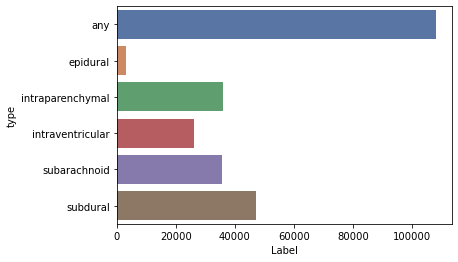

In [ ]:
sns.barplot(y=subtypes.index, x=subtypes.Label, palette="deep")

In [ ]:
np.random.seed(2019)
sample_files = np.random.choice(os.listdir(BASE_PATH + TRAIN_DIR), 40000) # take the rest for testing
sample_df = train_df[train_df.filename.apply(lambda x: x.replace('.png', '.dcm')).isin(sample_files)]

In [ ]:
pivot_df = sample_df[['Label', 'filename', 'type']].drop_duplicates().pivot(
    index='filename', columns='type', values='Label').reset_index()
print(pivot_df.shape)
print(pivot_df)

(33828, 7)
type           filename  any  epidural  intraparenchymal  intraventricular  \
0      ID_000039fa0.png    0         0                 0                 0   
1      ID_0000aee4b.png    0         0                 0                 0   
2      ID_000178e76.png    0         0                 0                 0   
3      ID_0001f7f62.png    0         0                 0                 0   
4      ID_0002003a8.png    0         0                 0                 0   
...                 ...  ...       ...               ...               ...   
33823  ID_27dce0288.png    0         0                 0                 0   
33824  ID_27ddeb81d.png    0         0                 0                 0   
33825  ID_27ddfa6c3.png    0         0                 0                 0   
33826  ID_27de23818.png    0         0                 0                 0   
33827  ID_27de7a9a4.png    0         0                 0                 0   

type   subarachnoid  subdural  
0                 0 

In [ ]:
test_df = sub_df[['Label', 'filename', 'type']].drop_duplicates().pivot(index='filename',columns='type', values='Label').reset_index()
print(test_df.shape)
test_df

(121232, 7)


type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000000e27.png,0.5,0.5,0.5,0.5,0.5,0.5
1,ID_000009146.png,0.5,0.5,0.5,0.5,0.5,0.5
2,ID_00007b8cb.png,0.5,0.5,0.5,0.5,0.5,0.5
3,ID_000134952.png,0.5,0.5,0.5,0.5,0.5,0.5
4,ID_000176f2a.png,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...
121227,ID_fffb40805.png,0.5,0.5,0.5,0.5,0.5,0.5
121228,ID_fffc74999.png,0.5,0.5,0.5,0.5,0.5,0.5
121229,ID_fffd3cc3b.png,0.5,0.5,0.5,0.5,0.5,0.5
121230,ID_fffdcca96.png,0.5,0.5,0.5,0.5,0.5,0.5


In [ ]:
np.random.seed(2021)
sample_test = np.random.choice(os.listdir(BASE_PATH + TEST_DIR), 5000)
test_sample_df = test_df[test_df.filename.apply(lambda x: x.replace('.png', '.dcm')).isin(sample_test)]
test_sample_df

type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
1,ID_000009146.png,0.5,0.5,0.5,0.5,0.5,0.5
3,ID_000134952.png,0.5,0.5,0.5,0.5,0.5,0.5
7,ID_000210e16.png,0.5,0.5,0.5,0.5,0.5,0.5
8,ID_0002bd10a.png,0.5,0.5,0.5,0.5,0.5,0.5
10,ID_000357857.png,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...
110489,ID_e9a5c5389.png,0.5,0.5,0.5,0.5,0.5,0.5
110490,ID_e9a8c20af.png,0.5,0.5,0.5,0.5,0.5,0.5
110493,ID_e9aa69a4f.png,0.5,0.5,0.5,0.5,0.5,0.5
110494,ID_e9ab783e4.png,0.5,0.5,0.5,0.5,0.5,0.5


In [ ]:
validation_df = pivot_df.sample(int(len(pivot_df) * 0.15)-2)
validation_df

type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
12362,ID_0ea0a5e73.png,0,0,0,0,0,0
32936,ID_26c52bdab.png,0,0,0,0,0,0
4879,ID_05dd3bf78.png,0,0,0,0,0,0
25080,ID_1d8e6ed14.png,0,0,0,0,0,0
2241,ID_02a8d0bfa.png,0,0,0,0,0,0
...,...,...,...,...,...,...,...
25798,ID_1e636af75.png,0,0,0,0,0,0
13904,ID_1065d02d0.png,1,0,0,0,1,0
3173,ID_03d39d113.png,0,0,0,0,0,0
8363,ID_09da88171.png,1,0,1,0,0,0


In [ ]:
y_true = []
for i in range(len(validation_df)): 
    y_true.append(validation_df.iloc[i,1])

In [ ]:
len(y_true)

5072

In [ ]:
full_true = []
for i in range((len(validation_df)-2)): 
    for j in range(1,7): 
        full_true.append(validation_df.iloc[i,j])


In [ ]:
len(full_true)

30420

In [ ]:
training_df = pivot_df[~(pivot_df.filename.isin(validation_df.filename))]
training_df

type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000039fa0.png,0,0,0,0,0,0
1,ID_0000aee4b.png,0,0,0,0,0,0
2,ID_000178e76.png,0,0,0,0,0,0
3,ID_0001f7f62.png,0,0,0,0,0,0
4,ID_0002003a8.png,0,0,0,0,0,0
...,...,...,...,...,...,...,...
33822,ID_27dc548ba.png,1,0,0,0,0,1
33823,ID_27dce0288.png,0,0,0,0,0,0
33824,ID_27ddeb81d.png,0,0,0,0,0,0
33825,ID_27ddfa6c3.png,0,0,0,0,0,0


In [ ]:
print(training_df.head())
print(validation_df.head())


type          filename  any  epidural  intraparenchymal  intraventricular  \
0     ID_000039fa0.png    0         0                 0                 0   
1     ID_0000aee4b.png    0         0                 0                 0   
2     ID_000178e76.png    0         0                 0                 0   
3     ID_0001f7f62.png    0         0                 0                 0   
4     ID_0002003a8.png    0         0                 0                 0   

type  subarachnoid  subdural  
0                0         0  
1                0         0  
2                0         0  
3                0         0  
4                0         0  
type           filename  any  epidural  intraparenchymal  intraventricular  \
12362  ID_0ea0a5e73.png    0         0                 0                 0   
32936  ID_26c52bdab.png    0         0                 0                 0   
4879   ID_05dd3bf78.png    0         0                 0                 0   
25080  ID_1d8e6ed14.png    0         0 

In [ ]:
def get_pixels_hu(scan): 
    image = np.stack([scan.pixel_array])
    image = image.astype(np.int16) 
    
    image[image == -2000] = 0
    
    intercept = scan.RescaleIntercept
    slope = scan.RescaleSlope
    
    if slope != 1: 
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
    
    image += np.int16(intercept) 
    
    return np.array(image, dtype=np.int16)

In [ ]:
def apply_window(image, center, width):
    image = image.copy()
    min_value = center - width // 2
    max_value = center + width // 2
    image[image < min_value] = min_value
    image[image > max_value] = max_value
    return image

In [ ]:
def apply_window_policy(image):

    image1 = apply_window(image, 40, 80) # brain
    image2 = apply_window(image, 80, 200) # subdural
    image3 = apply_window(image, 40, 380) # bone
    image1 = (image1 - 0) / 80
    image2 = (image2 - (-20)) / 200
    image3 = (image3 - (-150)) / 380
    image = np.array([
        image1 - image1.mean(),
        image2 - image2.mean(),
        image3 - image3.mean(),
    ]).transpose(1,2,0)

    return image

In [ ]:
def save_and_resize(filenames, load_dir):    
    save_dir = '/home/mtp2/rsna_data/png_train/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for filename in tqdm(filenames):
        try:
            path = load_dir + filename
            new_path = save_dir + filename.replace('.dcm', '.png')
            dcm = pydicom.dcmread(path, force=True)
            image = get_pixels_hu(dcm)
            image = apply_window_policy(image[0])
            image -= image.min((0,1))
            image = (255*image).astype(np.uint8)
            image = cv2.resize(image, (299, 299)) #smaller
            res = cv2.imwrite(new_path, image)
            
        except ValueError:
            continue # it returns a black image, super weird 

In [ ]:
save_and_resize(filenames=sample_files, load_dir=BASE_PATH + TRAIN_DIR)
save_and_resize(filenames=sample_test, load_dir=BASE_PATH + TEST_DIR)

100%|██████████| 5000/5000 [00:44<00:00, 111.83it/s]


In [ ]:
def create_model():    
    base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (299,299,3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.15)(x)
    y_pred = Dense(6, activation = 'sigmoid')(x)

    return Model(inputs = base_model.input, outputs = y_pred)

LR = 0.00005
model = create_model()

In [ ]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
model.compile(optimizer = Adam(learning_rate = LR), 
              loss = 'binary_crossentropy', # <- requires balance/ Binary for unbalanced
              metrics = [tf.keras.metrics.AUC()]) #run both 

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

BATCH_SIZE = 16 # had to revert back to 16 to have a comparaison point with the large model I ran locally 


In [ ]:
def create_datagen():
    return ImageDataGenerator(samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)

In [ ]:
def create_test_gen():
    return ImageDataGenerator().flow_from_dataframe(
        test_sample_df,
        directory=  '/home/mtp2/rsna_data/png_train/',
        x_col='filename',
        class_mode=None,
        target_size=(299, 299),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

In [ ]:
def create_train_gen(datagen):
    return datagen.flow_from_dataframe(
        training_df, 
        directory='/home/mtp2/rsna_data/png_train/',
        
        x_col='filename', 
        y_col=['any', 'epidural', 'intraparenchymal', 
               'intraventricular', 'subarachnoid', 'subdural'],
        class_mode='raw',
        target_size=(299, 299),
        batch_size=BATCH_SIZE,
    )

In [ ]:
def create_val_gen(datagen):   
    return datagen.flow_from_dataframe(
    validation_df, 
    directory='/home/mtp2/rsna_data/png_train/',
    
    x_col='filename', 
    y_col=['any', 'epidural', 'intraparenchymal', 
           'intraventricular', 'subarachnoid', 'subdural'],
    class_mode='raw',
    target_size=(299, 299),
    batch_size=BATCH_SIZE,
    shuffle=False,
    
)

In [ ]:
# Using original generator
data_generator = create_datagen()
train_gen = create_train_gen(data_generator)
val_gen = create_val_gen(data_generator)
test_gen = create_test_gen()

model.summary()


Found 28756 validated image filenames.
Found 5072 validated image filenames.
Found 3392 validated image filenames.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0]

In [ ]:
checkpoint = ModelCheckpoint(
    'effnetb4.h5', 
    monitor='val_loss', 
    verbose=0,
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)
Early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, 
                                              mode='auto', baseline=None, restore_best_weights=False)
#train_length = len(train_df)
total_steps = sample_files.shape[0] // BATCH_SIZE
total_steps = total_steps // 4
history = model.fit_generator(
    train_gen,
    steps_per_epoch = total_steps,
    validation_data=val_gen,
    validation_steps=total_steps * 0.15,
    epochs=15
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
625/625 [==============================] - 190s 303ms/step - loss: 0.1500 - auc: 0.8900 - val_loss: 0.1423 - val_auc: 0.9061
Epoch 2/15
625/625 [==============================] - 192s 307ms/step - loss: 0.1222 - auc: 0.9302 - val_loss: 0.1276 - val_auc: 0.9320
Epoch 3/15
625/625 [==============================] - 193s 308ms/step - loss: 0.1108 - auc: 0.9393 - val_loss: 0.0943 - val_auc: 0.9561
Epoch 4/15
625/625 [==============================] - 192s 307ms/step - loss: 0.1047 - auc: 0.9491 - val_loss: 0.1066 - val_auc: 0.9464
Epoch 5/15
625/625 [==============================] - 192s 307ms/step - loss: 0.1026 - auc: 0.9510 - val_loss: 0.0975 - val_auc: 0.9624
Epoch 6/15
625/625 [==============================] - 192s 306ms/step - loss: 0.0976 - auc: 0.9559 - val_loss: 0.1095 - val_auc: 0.9499
Epoch 7/15
625/625 [==============================] - 192s 307ms/step - loss: 0.0917 - auc: 0.9605 - val_los

In [ ]:
acc = history.history['auc']
val_acc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

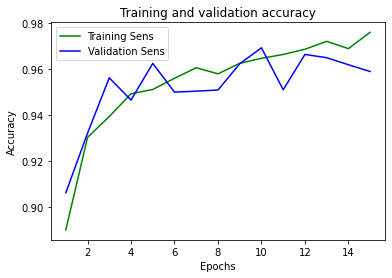

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, 'g', label='Training Sens')
plt.plot(epochs, val_acc, 'b', label='Validation Sens')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
fig.savefig('acc.png')

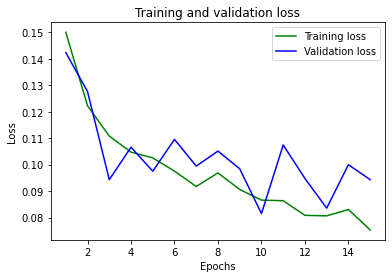

In [ ]:
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [ ]:
a = val_gen.n//val_gen.batch_size
print(a)

317


In [ ]:
val_gen.reset()
val_preds = model.predict_generator(val_gen,steps = a ,verbose = 1)

Instructions for updating:
Please use Model.predict, which supports generators.
317/317 [==============================] - 61s 192ms/step


In [ ]:
val_preds

array([[9.5418217e-03, 1.0478430e-04, 1.0459593e-04, 1.8599437e-04,
        6.7016622e-04, 2.1897348e-02],
       [1.7134940e-02, 2.8892775e-04, 4.2326958e-04, 5.8876898e-04,
        2.1724883e-03, 1.5681289e-02],
       [4.4215173e-03, 7.2908413e-05, 3.2414397e-04, 5.1260682e-05,
        1.7479357e-03, 5.6541576e-03],
       ...,
       [5.8697835e-02, 8.9712482e-04, 6.9118902e-04, 5.7754773e-05,
        4.6464242e-02, 2.0615675e-02],
       [6.5361321e-01, 6.3815934e-04, 6.4179316e-02, 8.9073545e-01,
        5.5407904e-02, 8.3872639e-03],
       [1.9793531e-04, 1.5022608e-06, 3.2641394e-06, 7.1496283e-06,
        1.6549595e-05, 2.4494034e-04]], dtype=float32)

In [ ]:
len(val_preds)

5072

In [ ]:
y_preds = []
for i in range(len(val_preds)):
    y_preds.append(0)
    for value in val_preds[i]: 
        if value > 0.5: 
            y_preds[i] = 1
            break

In [ ]:
len(y_preds)

5072

In [ ]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_preds)

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

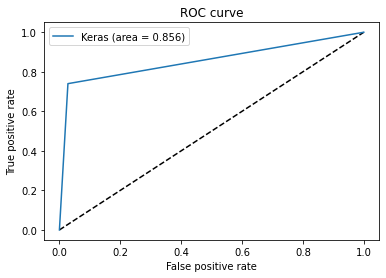

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
print('2*2 Confusion Matrix')
print(confusion_matrix(y_true, y_preds))
cm = confusion_matrix(y_true, y_preds)


2*2 Confusion Matrix
[[4205  121]
 [ 194  552]]


In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4205  121]
 [ 194  552]]


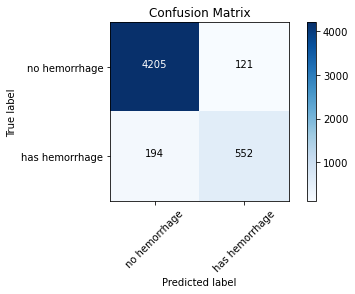

In [ ]:
cm_labels = ['no hemorrhage', 'has hemorrhage']

plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix')

In [ ]:
predictions_list = []
for pred in val_preds: 
    predictions_list.append(pred)

len(predictions_list)

5072

In [ ]:
validation_frame = validation_df.drop(['filename'], axis=1)
validation_frame 


type,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
12362,0,0,0,0,0,0
32936,0,0,0,0,0,0
4879,0,0,0,0,0,0
25080,0,0,0,0,0,0
2241,0,0,0,0,0,0
...,...,...,...,...,...,...
25798,0,0,0,0,0,0
13904,1,0,0,0,1,0
3173,0,0,0,0,0,0
8363,1,0,1,0,0,0


In [ ]:
len(validation_frame) 


5072

In [ ]:
if len(predictions_list) == len(validation_frame): 
    validation_frame.iloc[:,:] = predictions_list
else: 
    print("fix this issue")

In [ ]:
validation_frame.insert(0, "filename", validation_df.filename)
validation_frame.insert(7, "true_any" ,validation_df.iloc[:,1])
validation_frame.insert(8, "true_epidural", validation_df.epidural)
validation_frame.insert(9, "true_intraparenchymal", validation_df.intraparenchymal)
validation_frame.insert(10, "true_intraventricular", validation_df.intraventricular)
validation_frame.insert(11, "true_subarachnoid", validation_df.subarachnoid)
validation_frame.insert(12, "true_subdural", validation_df.subdural)

In [ ]:
validation_frame

type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,true_any,true_epidural,true_intraparenchymal,true_intraventricular,true_subarachnoid,true_subdural
12362,ID_0ea0a5e73.png,0.009542,0.000105,0.000105,0.000186,0.000670,0.021897,0,0,0,0,0,0
32936,ID_26c52bdab.png,0.017135,0.000289,0.000423,0.000589,0.002172,0.015681,0,0,0,0,0,0
4879,ID_05dd3bf78.png,0.004422,0.000073,0.000324,0.000051,0.001748,0.005654,0,0,0,0,0,0
25080,ID_1d8e6ed14.png,0.006755,0.000272,0.000907,0.002285,0.005928,0.001134,0,0,0,0,0,0
2241,ID_02a8d0bfa.png,0.001276,0.000016,0.000049,0.000016,0.000191,0.000603,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25798,ID_1e636af75.png,0.000691,0.000009,0.000034,0.000004,0.000250,0.000231,0,0,0,0,0,0
13904,ID_1065d02d0.png,0.967629,0.002171,0.038788,0.226378,0.963338,0.080286,1,0,0,0,1,0
3173,ID_03d39d113.png,0.058698,0.000897,0.000691,0.000058,0.046464,0.020616,0,0,0,0,0,0
8363,ID_09da88171.png,0.653613,0.000638,0.064179,0.890735,0.055408,0.008387,1,0,1,0,0,0


In [ ]:
for i in range(100): 
    if validation_frame.iloc[i,1] > 0.8: 
        print("ID is : " + str(validation_frame.iloc[i,0]))
        for j in range(1,7): 
            print("predicition = " +  str(validation_frame.iloc[i,j]) )
        for k in range(7,13): 
            print("true predicition = " +  str(validation_frame.iloc[i,k]))
# activation map

ID is : ID_0b60f9a47.png
predicition = 0.9961357712745667
predicition = 0.2647257149219513
predicition = 0.8359143733978271
predicition = 0.05961333215236664
predicition = 0.9140916466712952
predicition = 0.9394707083702087
true predicition = 1
true predicition = 0
true predicition = 0
true predicition = 0
true predicition = 1
true predicition = 1
ID is : ID_27ab36340.png
predicition = 0.9848816990852356
predicition = 0.11679680645465851
predicition = 0.8773651719093323
predicition = 0.10341556370258331
predicition = 0.76835036277771
predicition = 0.7899922132492065
true predicition = 1
true predicition = 0
true predicition = 1
true predicition = 0
true predicition = 0
true predicition = 1
ID is : ID_07fdde492.png
predicition = 0.9607380032539368
predicition = 0.048520710319280624
predicition = 0.6506600975990295
predicition = 0.25217992067337036
predicition = 0.6828969120979309
predicition = 0.39808303117752075
true predicition = 1
true predicition = 0
true predicition = 1
true predic

In [ ]:
any_preds = validation_frame['any']
max_index = any_preds.idxmax()
max_index

26828

In [ ]:
def img_to_heatmap(): 
    highest_predicted_img = validation_frame.loc[max_index,'filename']
    if validation_frame.loc[max_index, 'true_any'] == 1:
        return highest_predicted_img


In [ ]:
highest_predicted_img =  img_to_heatmap()
highest_predicted_img

'ID_1f9866a0e.png'

In [ ]:
b = test_gen.n//test_gen.batch_size
print(b)

212


In [ ]:
test_preds = model.predict_generator(test_gen,steps = b, verbose = 1)

212/212 [==============================] - 17s 79ms/step


In [ ]:
test_preds

array([[1.06819016e-07, 3.03848724e-09, 3.33817446e-10, 4.41876402e-09,
        4.02649192e-07, 3.30513529e-07],
       [6.57721444e-07, 1.05545910e-08, 3.20351523e-09, 2.40965576e-08,
        9.70278506e-06, 1.11496445e-06],
       [1.26246086e-05, 1.64778314e-07, 2.02939674e-08, 1.02708434e-07,
        1.82147647e-04, 3.83981678e-05],
       ...,
       [1.71627212e-09, 2.66564104e-10, 2.15986951e-12, 5.97220540e-09,
        3.84228116e-07, 1.59413798e-08],
       [1.68550017e-07, 4.22252278e-09, 1.87044802e-09, 1.35053213e-08,
        3.16726130e-07, 1.05345282e-06],
       [5.49143413e-12, 2.42203582e-13, 1.49030841e-15, 1.73484612e-11,
        9.20078680e-09, 1.36348953e-11]], dtype=float32)

In [ ]:
len(test_preds)

3392

In [ ]:
predictions_list_test = []
for pred in test_preds: 
    predictions_list_test.append(pred)

In [ ]:
test_frame =  test_sample_df.drop(['filename'], axis=1)
test_frame


type,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
1,0.5,0.5,0.5,0.5,0.5,0.5
3,0.5,0.5,0.5,0.5,0.5,0.5
7,0.5,0.5,0.5,0.5,0.5,0.5
8,0.5,0.5,0.5,0.5,0.5,0.5
10,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...
110489,0.5,0.5,0.5,0.5,0.5,0.5
110490,0.5,0.5,0.5,0.5,0.5,0.5
110493,0.5,0.5,0.5,0.5,0.5,0.5
110494,0.5,0.5,0.5,0.5,0.5,0.5


In [ ]:
test_frame.iloc[:,:] = predictions_list_test
test_frame

type,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
1,1.068190e-07,3.038487e-09,3.338174e-10,4.418764e-09,4.026492e-07,3.305135e-07
3,6.577214e-07,1.055459e-08,3.203515e-09,2.409656e-08,9.702785e-06,1.114964e-06
7,1.262461e-05,1.647783e-07,2.029397e-08,1.027084e-07,1.821476e-04,3.839817e-05
8,2.164112e-06,1.704497e-07,7.991419e-09,2.019501e-07,1.175735e-04,3.056359e-06
10,1.134909e-07,2.743767e-09,2.343331e-09,3.061128e-08,1.773279e-06,1.896851e-07
...,...,...,...,...,...,...
110489,9.174824e-06,1.174354e-07,5.154396e-09,1.824307e-07,9.732440e-06,6.663444e-05
110490,1.810807e-06,1.136169e-08,2.506296e-08,6.027769e-08,2.027354e-06,9.897494e-06
110493,1.716272e-09,2.665641e-10,2.159870e-12,5.972205e-09,3.842281e-07,1.594138e-08
110494,1.685500e-07,4.222523e-09,1.870448e-09,1.350532e-08,3.167261e-07,1.053453e-06


In [ ]:
test_frame.insert(0, "filename", test_df.filename)
test_frame

type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
1,ID_000009146.png,1.068190e-07,3.038487e-09,3.338174e-10,4.418764e-09,4.026492e-07,3.305135e-07
3,ID_000134952.png,6.577214e-07,1.055459e-08,3.203515e-09,2.409656e-08,9.702785e-06,1.114964e-06
7,ID_000210e16.png,1.262461e-05,1.647783e-07,2.029397e-08,1.027084e-07,1.821476e-04,3.839817e-05
8,ID_0002bd10a.png,2.164112e-06,1.704497e-07,7.991419e-09,2.019501e-07,1.175735e-04,3.056359e-06
10,ID_000357857.png,1.134909e-07,2.743767e-09,2.343331e-09,3.061128e-08,1.773279e-06,1.896851e-07
...,...,...,...,...,...,...,...
110489,ID_e9a5c5389.png,9.174824e-06,1.174354e-07,5.154396e-09,1.824307e-07,9.732440e-06,6.663444e-05
110490,ID_e9a8c20af.png,1.810807e-06,1.136169e-08,2.506296e-08,6.027769e-08,2.027354e-06,9.897494e-06
110493,ID_e9aa69a4f.png,1.716272e-09,2.665641e-10,2.159870e-12,5.972205e-09,3.842281e-07,1.594138e-08
110494,ID_e9ab783e4.png,1.685500e-07,4.222523e-09,1.870448e-09,1.350532e-08,3.167261e-07,1.053453e-06


In [ ]:
from PIL import Image
for i in range(20): 
  
    for j in range(1,7): 
        if test_frame.iloc[i,j] > 0.8: 
            path = '/home/mtp2/rsna_data/png_train/' + str(test_frame.iloc[i,0])
            img = Image.open(path)
            plt.imshow(img)
            print(str(test_frame.iloc[i,0]) + " has a probability: "  + str(test_frame.iloc[i,j]) + " for a '" + str(test_frame.columns[j]) + "' type of hemorrhage")
            plt.show()

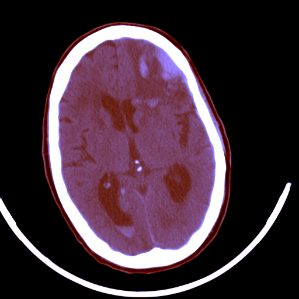

In [ ]:
#heatmap 
#The code used to show the heatmake was taken from: https://keras.io/examples/vision/grad_cam/
#Only slightly modified to fit this workflow and return the image with the highest predicition from the validtion set 
from IPython.display import Image, display
from tensorflow import keras

preprocess_input = keras.applications.resnet50.preprocess_input
decode_predictions = keras.applications.resnet50.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

img_path = '/home/mtp2/rsna_data/png_train/' + str(highest_predicted_img)
display(Image(img_path))



In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
img_size = (299, 299)

img_array = preprocess_input(get_img_array(img_path, size=img_size))

model.layers[-1].activation = None

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

ValueError: No such layer: block14_sepconv2_act

In [ ]:
import matplotlib.cm as cm
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [ ]:
save_and_display_gradcam(img_path, heatmap)